#  Instruction

In this notebook, we will learn how to implement DQN using Tensorflow for the [Cartpole environment in OpenAI gym](https://gym.openai.com/envs/CartPole-v0/). You are given a basic skeleton but you need to complete the code where appropriate to solve the cartpole problem.

You are free to tweak the code at any part. Your are also free to tweak the hyper-parameters to improve the performance of the agent. At the end you have to evaluate the performance of the agent on 100 independent episodes on the environment and print out the average testing performance.

Make sure that your final submission is a notebook that can be run from beginning to end, and that you print out the performance of the agent at the end of the notebook.

In [1]:
%matplotlib inline

import tensorflow as tf
from collections import deque
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gym
from tensorflow import keras
from tensorflow.keras import layers
import random
import seaborn as sns

In [2]:
# Parameters
gamma = 0.99  # discount 
envname = "CartPole-v0"  # environment name
env = gym.make(envname)
obssize = env.observation_space.low.size
actsize = env.action_space.n

In [3]:
def print_debug(x):
    debug = False
    if debug:
        print(x)
    else:
        pass

In [4]:
print_debug("obssize : {}".format(obssize))
print_debug("actsize : {}".format(actsize))

## DQN (Deep Q Network)

In previous HWs, we have learned to use Tensorflow to build deep learning models. In this HW, we will apply deep learning as function approximations in reinforcement learning. 

Reference: DQN https://arxiv.org/abs/1312.5602


In tabular Q-learning, we maintain a table of state-action pairs $(s,a)$ and save one action value for each entry $Q(s,a),\forall (s,a)$. At each time step $t$, we are in state $s_t$, then we choose action based on $\epsilon-$greedy strategy. With prob $\epsilon$, choose action uniformly random; with prob $1-\epsilon$, choose action based on $$a_t = \arg\max_a Q(s_t,a)$$ 

We then get the instant reward $r_t$, update the Q-table using the following rule

$$Q(s_t,a_t) \leftarrow (1-\alpha)Q(s_t,a_t) + \alpha (r_t + \max_a \gamma Q(s_{t+1},a))$$

where $\alpha \in (0,1)$ is learning rate. The algorithm is shown to converge in tabular cases. However, in cases where we cannot keep a table for state and action, we need function approximation. Consider using neural network with parameter $\theta$, the network takes as input state $s$ and action $a$. (*or some features of state and action*). Let $Q_\theta(s,a)$ be the output of the network, which estimates the optimal Q-value function for state $s$ and action $a$.
$$Q_\theta(s,a) \approx Q^\ast(s,a)$$

In [5]:
def model_creator():
    model = keras.Sequential()
    model.add(layers.Dense(64,activation="relu"))
    model.add(layers.Dense(128,activation="relu"))
    model.add(layers.Dense(actsize,activation="linear")) # you should have one output for each possible action
    return model

We wish to train the neural network in order to find $\theta$ such that $Q_\theta(s,a)$ approximates $Q^*(s,a)$. As we discussed in the class, we can use observations of form $(s_i, a_i, r_i, s'_{i})$ (i.e., observing reward $r_i$ and new state $s'_{i}$ on taking action $a_i$ in state $s_i$) for training. Based on observations, we can use stochastic gradient descent to update $\theta$ in the direction that minimizes the loss function. Further, based on values $Q_\theta(s,a)$, we can choose the action based on $\epsilon$-greedy policy.

Formally let $d_i$ be the target for the $i$-th sample $(s_t,a_t,r_t,s_{t+1})$

$$d_i =  r_t +   \gamma \max_a Q_\theta(s_{t+1},a)$$

We can collect a batch of $N$ samples (this generalizes the per sample update $N=1$ discusssed in class), consider the loss fucntion,

$$J:=\frac{1}{N} \sum_{i=1}^N (Q_\theta(s_i,a_i) - d_i)^2$$

and update

$$
\theta \leftarrow \theta -\alpha \nabla_\theta J
$$

This procedure has been shown to be fairly unstable. In class, we discussed two techniques to stabilize the training process: target network and replay buffer.

**Replay Buffer**
Maintain a buffer $R$ to store trainsition tuples $(s_t,a_t,r_t,s_{t+1})$. When minimizing the loss, we sample batches from the replay buffer and compute gradients for update on these batches. In particular, in each update, we sample $N$ tuples $(s_t,a_t,r_t,s_{t+1})$ from buffer $R$ and then minimize the
loss 

$$\frac{1}{N} \sum_{i=1}^N (Q_\theta(s_i,a_i) -  (r_i + \gamma \max_a Q_\theta(s_i^\prime,a))^2$$

and update parameters.

**Target Network**
Maintain a target network in addition to the original principal network. The target network is just a copy of the original network but the parameters are not updated by gradients. The target network $\theta^{-}$ is copied from the principal network every $\tau$ time steps. Target network is used to compute the targets for update

$$d_i = \max_a r_t + \gamma Q_{\theta^{-}}(s_{i}^\prime,a)$$

the targets are used in the loss function to update the principal network parameters. This slowly updated target network ensures that the targets come from a relatively stationary distribution and hence stabilize learning.

In [6]:
batch_size = 32
# Model used for selecting actions (principal)
model = model_creator()
# Then create the target model. This will periodically be copied from the principal network 
model_target = model_creator()

model.build((batch_size,obssize,))
model_target.build((batch_size,obssize,))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (32, 64)                  320       
                                                                 
 dense_1 (Dense)             (32, 128)                 8320      
                                                                 
 dense_2 (Dense)             (32, 2)                   258       
                                                                 
Total params: 8,898
Trainable params: 8,898
Non-trainable params: 0
_________________________________________________________________


- Complete the code below to learn an Agent using DQN. 
- You should tweak the Neural network appropriately to achieve a good reward (>100). Ideally you would want to have a reward close to 200.
- The reference paper performs updates every 4 actions. You can experiment with this parameter to speed up the learning
- You can experiment with other parameters as well, like learning rate, memory size, different exploration schemes (e.g., adaptive $\epsilon$ or strategic explorations with bonus rewards) and others.

- As we mentioned in class, there are multiple ways to improve the efficiency even further. OPTIONALLY you can experiment with these:
  - Prioritized Replay buffer.
  - Double DQN 
  -Dueling DQN architecture.

- In case you need to debug your code you can try printing relevant information as the training happens. For example although the performance might vary from iteration to iteration, the average Q values might increase overtime in a more smooth way. This is discussed in the refernece paper

- Create a plot of the running reward sampled throughout the training at the frequency of your choice at the end of the training
- OPTIONALLY you can create a plot for the average Q-values of the principal Q-network sampled at the frequency of your choice

- Ideally you want to learn with as few episodes as possible. However you will not be graded on sample efficiency in this homework. You encouraged to try to learn efficiently though.

- Note that the skeleton code includes the GradientTape construct to do the learning. Take a look [here](https://www.tensorflow.org/api_docs/python/tf/GradientTape) for an explanation of GradientTape. It allows for more flexibility than model.fit. Also it uses Adam (Adaptive Moment Estimation) for Stochastic Gradient Descent optimizer. 

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

# Our Experience Replay memory 
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
loss_history = []
q_predict_history = []
q_target_history = []
full_reward_history = []

# Replay memory size
max_memory = 1000 # You can experiment with different sizes.

running_reward = 0
running_loss = 0
episode_count = 0
timestep_count = 0
running_q_predict = 0
running_q_target = 0

# how often to train your model - this allows you to speed up learning
# by not performing in every iteration learning. See also refernece paper
# you can set this value to other values like 1 as well to learn every time 

update_after_actions = 2

# How often to update the target network
record_reward_every = 1
target_update_every = 1000
loss_function = keras.losses.MeanSquaredError() # You can use the Huber loss function or the mean squared error function 
max_episodes = 500
max_steps_per_episode = 1000
last_n_reward = 100
penalty = 3.

epsilon = 1.
min_epsilon = 0.01
epsilon_decay = 0.99

for episode in range(max_episodes):
    state = np.array(env.reset())
    episode_reward = 0
    epsilon = epsilon * epsilon_decay
    epsilon = max(epsilon, min_epsilon)
    for timestep in range(1, max_steps_per_episode):
        timestep_count += 1
        prob = np.random.random()
        if prob < epsilon:
            # Take random action
            action = np.random.choice(actsize)
        else:
            # Predict action Q-values
            # From environment state
            state_t = tf.convert_to_tensor(state)
            state_t = tf.expand_dims(state_t, 0)
            action_vals = model(state_t, training=False)
            action = tf.math.argmax(tf.squeeze(action_vals)).numpy().item()

        # follow selected action
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)
        episode_reward += reward

        # Save action/states and other information in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        rewards_history.append(reward)
        done_history.append(done)
        episode_reward_history.append(episode_reward)

        state = state_next

        # Update every Xth frame to speed up (optional)
        # and if you have sufficient history
        if timestep_count % update_after_actions == 0 and len(action_history) > batch_size:

            n_history = len(action_history)
            indices = list(range(n_history))
            sampled_indices = random.sample(indices, batch_size)

            #  Sample a set of batch_size memories from the history
            state_sample = np.array([state_history[x] for x in sampled_indices])
            state_next_sample = np.array([state_next_history[x] for x in sampled_indices])
            rewards_sample = np.array([rewards_history[x] for x in sampled_indices])
            action_sample = np.array([action_history[x] for x in sampled_indices])
            done_sample = np.array([done_history[x] for x in sampled_indices])

            Q_next_state = model_target(tf.convert_to_tensor(state_next_sample), training=False).numpy().max(axis=1)
            Q_targets = tf.convert_to_tensor(rewards_sample + (gamma * Q_next_state))
            print_debug("reward_sample : {}".format(rewards_sample))
            print_debug("Q_targets : {}".format(Q_targets))
            Q_targets = Q_targets * (1 - done_sample) - penalty * done_sample

            # What actions are relevant and need updating
            relevant_actions = tf.one_hot(action_sample, actsize)
            # we will use Gradient tape to do a custom gradient 
            # in the `with` environment we will record a set of operations
            # and then we will take gradients with respect to the trainable parameters
            # in the neural network
            with tf.GradientTape() as tape:
                # Train the model on your action selecting network
                q_values = model(state_sample) 
                # We consider only the relevant actions
                Q_of_actions = tf.reduce_sum(tf.multiply(q_values, relevant_actions), axis=1)
                print_debug("relevant_actions : {}".format(relevant_actions))
                print_debug("Q_of_actions : {}".format(Q_of_actions))
                # Calculate loss between principal network and target network
                loss = loss_function(Q_targets, Q_of_actions)
                print_debug("loss : {}".format(loss))

            # Nudge the weights of the trainable variables towards 
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            loss_history.append(loss.numpy().item())
            q_predict_history.append(Q_of_actions.numpy().mean())
            q_target_history.append(Q_targets.numpy().mean())

        if timestep_count % target_update_every == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {}, loss_history {}, q_predict {}, q_target {}"
            print(template.format(running_reward, episode_count, timestep_count, epsilon, running_loss, running_q_predict, running_q_target))

        # Don't let the memory grow beyond the limit
        if len(rewards_history) > max_memory:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done: 
            break

    # reward of last 100
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > last_n_reward: 
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    episode_count += 1
    if episode_count % record_reward_every == 0:
        full_reward_history.append(episode_reward)
    running_loss = np.mean(loss_history)
    running_q_predict = np.mean(q_predict_history)
    running_q_target = np.mean(q_target_history)

    # If you want to stop your training once you achieve the reward you want you can
    # have an if statement here. Alternatively you can stop after a fixed number
    # of episodes.

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


running reward: 11.93 at episode 58, frame count 1000, epsilon 0.5526834771623851, loss_history 0.8651453799324659, q_predict 0.7149983644485474, q_target 0.8193009350987425
running reward: 19.23 at episode 88, frame count 2000, epsilon 0.40882017442254937, loss_history 0.7227969059921228, q_predict 1.2086701393127441, q_target 1.266821061071038
running reward: 25.90 at episode 105, frame count 3000, epsilon 0.34461218334751764, loss_history 0.6288924561677074, q_predict 1.7365140914916992, q_target 1.7781479391598527
running reward: 40.54 at episode 113, frame count 4000, epsilon 0.3179890638191435, loss_history 0.5223666549576503, q_predict 2.2873332500457764, q_target 2.3206605811222323
running reward: 50.41 at episode 119, frame count 5000, epsilon 0.29938039131233124, loss_history 0.4839394021201954, q_predict 2.822094678878784, q_target 2.8499157180602217
running reward: 57.43 at episode 124, frame count 6000, epsilon 0.2847077732731954, loss_history 0.44929741880908264, q_predic

Evaluate the performance of the agent on 100 episodes on the environment and print out the average testing performance. Alternatively you can make sure the code above terminates with 100 episodes where there is no exploration at all (epsilon=0).

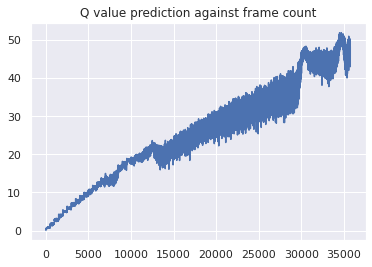

In [16]:
sns.set()
plt.plot(range(len(q_predict_history)), q_predict_history)
plt.title("Q value prediction against frame count")
plt.show()

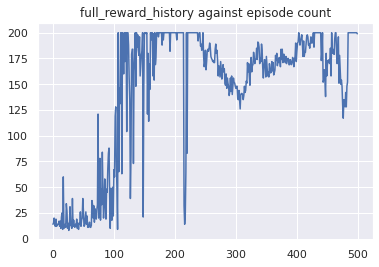

In [17]:
sns.set()
plt.plot(range(len(full_reward_history)), full_reward_history)
plt.title("full_reward_history against episode count")
plt.show()

In [9]:
rewards = []

for episode in range(100):
    state = np.array(env.reset())
    episode_reward = 0
    for timestep in range(1, 1000):
        state_t = tf.convert_to_tensor(state)
        state_t = tf.expand_dims(state_t, 0)
        action_vals = model(state_t, training=False)
        action = tf.math.argmax(tf.squeeze(action_vals)).numpy().item()

        # follow selected action
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)
        episode_reward += reward
        state = state_next
        if done:
            break
    rewards.append(episode_reward)

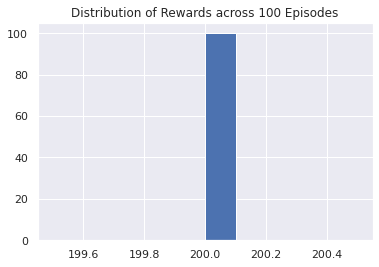

In [10]:
sns.set()
plt.hist(rewards)
plt.title("Distribution of Rewards across 100 Episodes")
plt.show()